### This is a notebook for running spatial analysis on paired FOVs and cell tables generated via the `Segment_Image_Data.ipynb` notebook.

In [1]:
# Import all the necessary packages
import os

import numpy as np
import pandas as pd
import xarray as xr
from alpineer import io_utils, misc_utils

import ark.settings as settings
from ark.analysis import spatial_analysis, visualize
from ark.utils import example_dataset, spatial_analysis_utils

In [2]:
# This script takes a cell expression matrix, label maps for the fovs to be included in the analysis, and, depending
# on the analysis, a threshold matrix for channel or cluster spatial analysis. In channel spatial analysis, cells for
# a specific fov are identified, and cells of particular phenotypes are compared to each other to check for positive,
# negative, or no enrichment. To do this, a distance matrix is created from the segmented label maps, cell phenotypes are
# identified by their labels in the image and then significant interactions between different populations of phenotypes
# are recorded. Similar analysis is also done for channel spatial enrichment; however, instead of looking at cell
# phenotypes, markers positive for specific thresholds are identified and specific interactions are then characterized
# between them.

### Download the Example Dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change the `base_dir` to point to your own sub-directory within the data folder, rather than `'example_dataset'`. 

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook.

In [3]:
# Set up file paths and import data
base_dir = "../data/example_dataset/"

If you would like to test the features in Ark with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels. You may find more information about the example dataset in the [README](../README.md#example-dataset).

* `overwrite_existing`: If set to `False`, it will not overwrite existing data in the `data/example_dataset`. Recommended setting it to `True` if you have not run Notebooks 1-4.

In [ ]:
example_dataset.get_example_dataset(dataset="pairwise_spatial_enrichment", save_dir=base_dir, overwrite_existing=True)

In [5]:
cell_table_path = os.path.join(base_dir, "segmentation/cell_table/cell_table_size_normalized_cell_labels.csv")
marker_thresholds_path = os.path.join(base_dir, "post_clustering/marker_thresholds.csv")
deepcell_output = os.path.join(base_dir, "segmentation/deepcell_output")
dist_mat_dir = os.path.join(base_dir, "spatial_analysis/pairwise_spatial_enrichment/dist_mats")

# validate file paths (add other directories as needed)
io_utils.validate_paths([
    base_dir,
    cell_table_path,
    marker_thresholds_path,
    deepcell_output,
])

### Loading in generated cell tables from csv file

In [6]:
# Import the necessary data
# This is the cell expression matrix including data for fovs 6 and 7, their cell labels, marker expression,
# cell phenotypes (cell_type), and cell phenotype IDs.
all_data = pd.read_csv(cell_table_path)

### Loading user specified marker thresholds from csv file

If you're only trying to look at cluster based spatial analysis, you may skip this step.

Support for programmatic generation of marker thresholds may be available in the future.

In [7]:
# This is the threshold matrix with all marker thresholds - for channel cpatial enrichment
marker_thresholds = pd.read_csv(marker_thresholds_path, dtype = {"marker": str, "threshold": float})

### Create the distance matrices

Create the distance matrices to use for spatial analysis. The matrix for each FOV will will be saved to the `dist_mat_output` folder in the format `{fov_name}_dist_mat.xr`.

<b>NOTE:</b> this step is skipped if the distance matrices have already been created.

In [ ]:
# create the dist_mat_output directory if it doesn't exist
if not os.path.exists(dist_mat_dir):
    os.makedirs(dist_mat_dir)
    spatial_analysis_utils.calc_dist_matrix(deepcell_output, dist_mat_dir)
    
# verify all the FOVs computed exist in all_data
misc_utils.verify_in_list(
    dist_mat_fovs=[f.replace('_dist_mat.xr', '') for f in io_utils.list_files(dist_mat_dir, substrs='_dist_mat.xr')],
    input_fovs=all_data[settings.FOV_ID].unique()
)

### Channels excluded from spatial analysis

These will generally be non biologically significant channels, or channels which won't posess
interesting spatial distribution. Set to `None` to keep all the channels.

In [9]:
excluded_channels = [
    "CD4",
    "Vim",
    "Fibronectin",
]

### Compute spatial enrichment for channel expression in cells

If you're not interested in channel expression, or don't have marker thresholds, continue to the
below step.

In [ ]:
values_channel, stats_channel = spatial_analysis.generate_channel_spatial_enrichment_stats(
    deepcell_output, dist_mat_dir, marker_thresholds, all_data,
    excluded_channels=excluded_channels, bootstrap_num=5
)

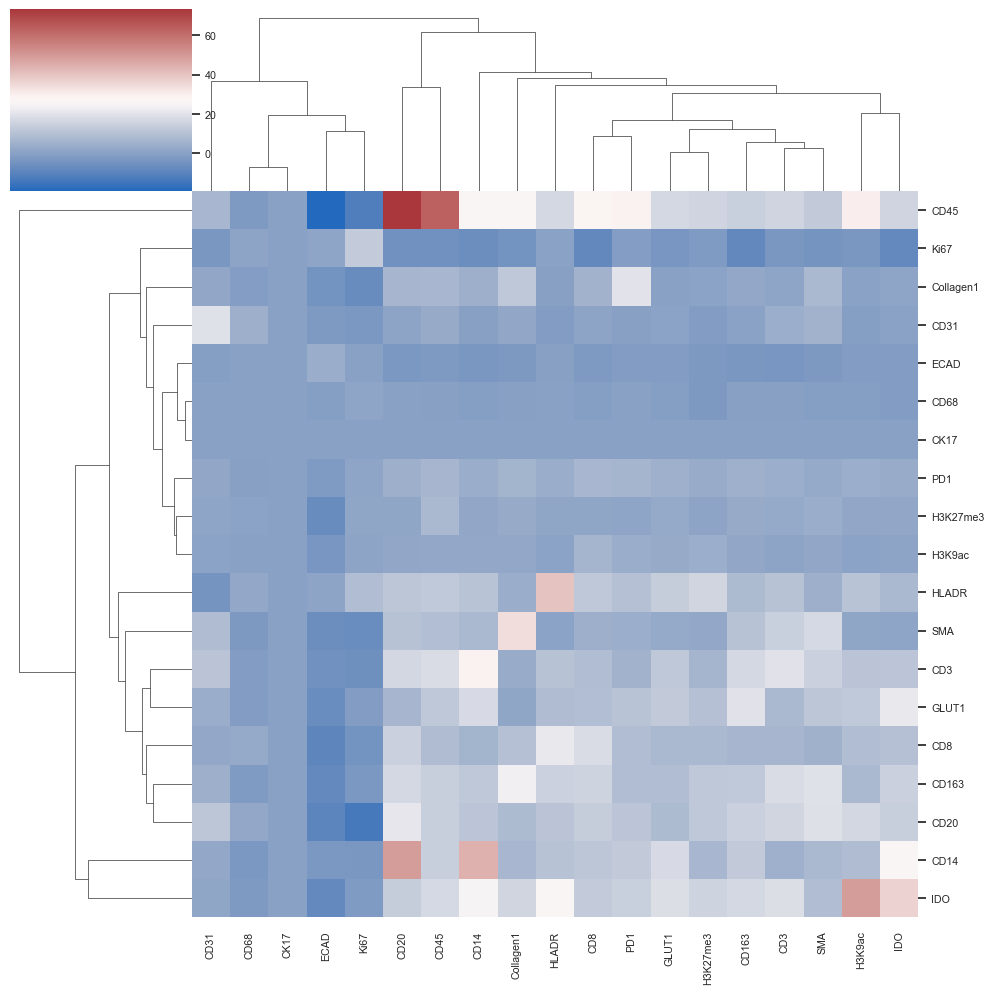

In [11]:
# For channel spatial analysis, first find all the marker titles to use as input for the clustergram
channel_start = np.where(all_data.columns == settings.PRE_CHANNEL_COL)[0][0] + 1
channel_end = np.where(all_data.columns == settings.POST_CHANNEL_COL)[0][0]

marker_titles = all_data.iloc[:, channel_start:channel_end].drop(excluded_channels if excluded_channels is not None else [], axis=1).columns
visualize.draw_heatmap(stats_channel.loc['fov6', "z", :, :].values, marker_titles, marker_titles)

### Compute spatial enrichment for cluster identity of cells

If you don't have cluster data, skip this step.  A cell clustering notebook will be released
shortly to fascilitate this step.

In [ ]:
values_cluster, stats_cluster = spatial_analysis.generate_cluster_spatial_enrichment_stats(
    deepcell_output, dist_mat_dir, all_data, bootstrap_num=5
)

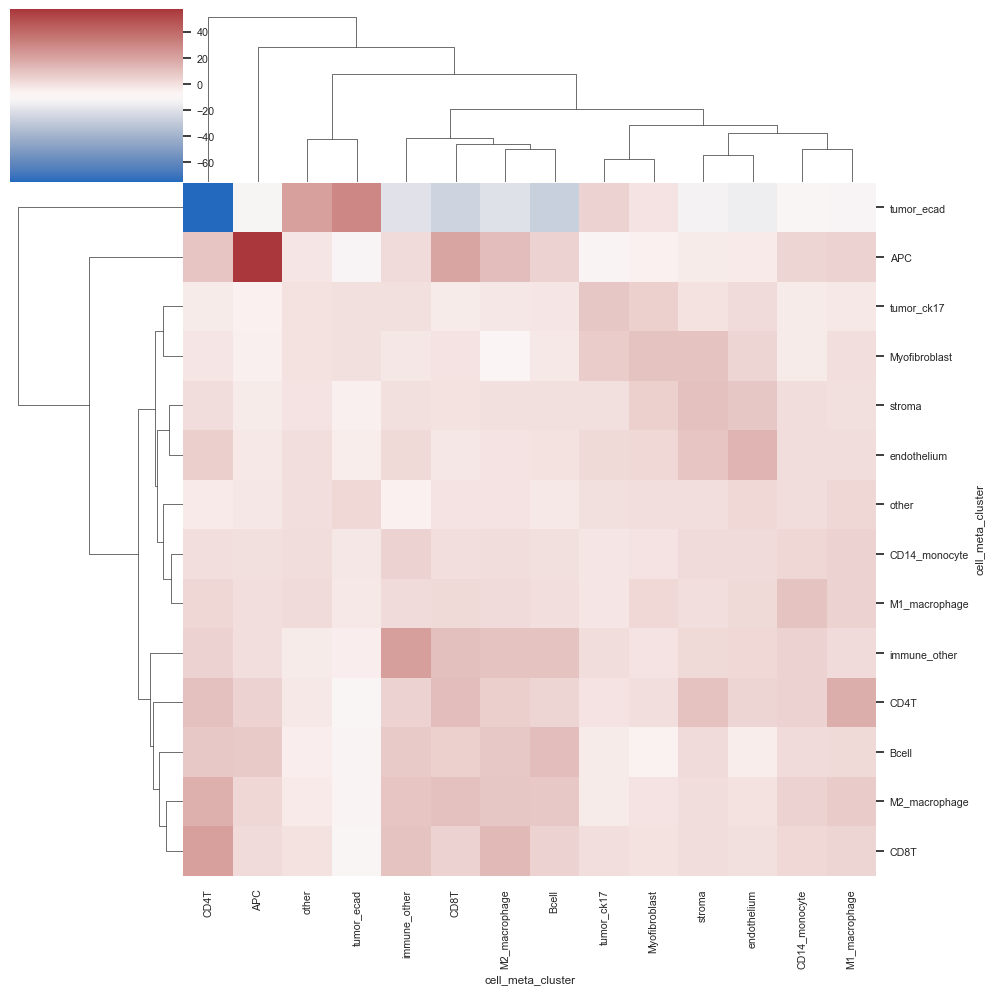

In [13]:
# To visualize the z scores, a clustermap can be produced
# For cluster spatial analysis, first find all the cell phenotypes in the data to use as an input for the clustergram
pheno_titles = all_data[settings.CELL_TYPE].drop_duplicates()
visualize.draw_heatmap(stats_cluster.loc['fov6', "z", :, :].values, pheno_titles, pheno_titles)